**_Note:_** examples here use the python interface of the parser but it's identical to parser's cli

In [1]:
import df_script_parser
from pathlib import Path
from tempfile import mkdtemp

In [2]:
example_dir = Path(mkdtemp())

## 1. Basic examples

This basic example shows that parser can extract import, dictionaries, function calls as well as project requirements.

In [3]:
working_dir = example_dir / "basic_example"
working_dir.mkdir()
main_file = working_dir / "main.py"
main_file.touch()
yaml_file = working_dir / "script.yaml"

In [4]:
with open(main_file, "w") as main:
    main.write("""
from pathlib import Path
import df_engine as dfe
import mypackage

dictionary = {
    1: Path,
    2: dfe,
    3: {4: mypackage},
    4: "text",
}

result = this_function_does_not_exist(dictionary)
    """)

df_script_parser.py2yaml(
    root_file=main_file,
    project_root_dir=working_dir,
    output_file=yaml_file
)

with open(yaml_file, "r") as out:
    print(out.read())

requirements:
- df-engine==0.9.0
- git+https://github.com/navdeep-G/setup.py.git@3a03ee20c0d2b795c8d5cb1aa1d7c3c6468d2ffc
namespaces:
  main:
    Path: !from pathlib Path
    dfe: !import df_engine
    mypackage: !import mypackage
    dictionary:
      '1': Path
      '2': dfe
      '3':
        '4': mypackage
      '4': text
    result: !call
      name: this_function_does_not_exist
      args:
        0: dictionary



In [5]:
df_script_parser.yaml2py(
    yaml_file=yaml_file,
    extract_to_directory=working_dir
)

with open(main_file, "r") as out:
    print(out.read())

from pathlib import Path as Path
import df_engine as dfe
import mypackage as mypackage

dictionary = {1: Path, 2: dfe, 3: {4: mypackage}, 4: "text"}
result = this_function_does_not_exist(dictionary)



In [6]:
with open(working_dir / "requirements.txt", "r") as reqs:
    print(reqs.read())

df-engine==0.9.0
git+https://github.com/navdeep-G/setup.py.git@3a03ee20c0d2b795c8d5cb1aa1d7c3c6468d2ffc


**_Note:_** if you want to override those requirements use the ``requirements`` flag of ``df_script_parser.py2yaml``

## 2. Str tag

As you can see in a previous example both dictionary values ``Path`` and ``text`` are written in plain text. How did ``yaml2py`` parser figure out that it needs to put quotations around ``text``? Parser checks every plain text on whether it could be a correct line of python code. If it isn't parser knows that it's a string.

But what if you want to use a string that is also a correct line of python code? That's where ``!str`` tag comes in:

In [7]:
working_dir = example_dir / "str_tag"
working_dir.mkdir()
main_file = working_dir / "main.py"
main_file.touch()
yaml_file = working_dir / "script.yaml"

In [8]:
with open(main_file, "w") as main:
    main.write("""
from pathlib import Path

dictionary = {
    1: Path,
    2: "Path",
    3: print,
    4: "print",
    5: printd,
    6: "printd"
}

    """)

df_script_parser.py2yaml(
    root_file=main_file,
    project_root_dir=working_dir,
    output_file=yaml_file
)

with open(yaml_file, "r") as out:
    print(out.read())

requirements: []
namespaces:
  main:
    Path: !from pathlib Path
    dictionary:
      '1': Path
      '2': !str Path
      '3': print
      '4': !str print
      '5': !py printd
      '6': printd



In [9]:
df_script_parser.yaml2py(
    yaml_file=yaml_file,
    extract_to_directory=working_dir
)

with open(main_file, "r") as out:
    print(out.read())

from pathlib import Path as Path

dictionary = {1: Path, 2: "Path", 3: print, 4: "print", 5: printd, 6: "printd"}



if you want to specify if the parser should treat a value as a string or as a python line of code you could use tags ``!str`` or ``!py`` respectively.

## 3. Recursive parsing

If your projects contains several modules that are imported in your ``root_file`` they will be parsed as well:

In [10]:
working_dir = example_dir / "recursive_parsing"
working_dir.mkdir()
python_files = working_dir / "python_files"
python_files.mkdir()
main_file = python_files / "main.py"
main_file.touch()

some_package = python_files / "some_package"
some_package.mkdir()
(some_package / "__init__.py").touch()
another_file = some_package / "another_file.py"
another_file.touch()
unparsed = python_files / "unparsed.py"
unparsed.touch()
yaml_file = working_dir / "script.yaml"

The project has the following structure:

``
+-- python_files
+--++-- main.py
+--++-- some_package
+--++--++-- another_file.py
+--++-- unparsed.py
``

In [11]:
with open(main_file, "w") as main:
    main.write("""
from some_package import another_file
from some_package.another_file import something, something_else
import unparsed

dictionary = {
    1: something,
    2: something_else,
    3: unparsed.path
}

    """)
    
with open(another_file, "w") as file:
    file.write("""
import abc as something

    """)
    
with open(unparsed, "w") as file:
    file.write("""
from pathlib import Path as path

print(path)

    """)

df_script_parser.py2yaml(
    root_file=main_file,
    project_root_dir=python_files,
    output_file=yaml_file
)

with open(yaml_file, "r") as out:
    print(out.read())

            The first line of other type found: print(path)


requirements: []
namespaces:
  main:
    another_file: !from some_package another_file
    something: !from some_package.another_file something
    something_else: !from some_package.another_file something_else
    unparsed: !import unparsed
    dictionary:
      '1': something
      '2': something_else
      '3': unparsed.path
  some_package.__init__: {}
  some_package.another_file:
    something: !import abc



As you can see ``unparsed.py`` wasn't parsed as it doesn't follow the parser structure rules described in [README.md](../README.md). Replacing ``print(path)`` with ``some_variable = print(path)`` will fix that issue.

**_Note:_** If ``project_root_dir`` contains ``__init__.py`` file ``yaml2py`` parser will put all the files inside a new directory with the same name as ``project_root_dir`` inside ``extract_to_directory``. So the result will be:

``
+-- extract_to_directory
+--++-- project_root_dir
+--++--++-- __init__.py
+--++--++-- ...
``

## 4. Actor arg checking

If your script contains a call to ``df_engine.core.Actor`` or ``df_engine.core.actor.Actor`` the arguments of that call will be checked.

In [12]:
working_dir = example_dir / "act_arg"
working_dir.mkdir()
main_file = working_dir / "main.py"
main_file.touch()
yaml_file = working_dir / "script.yaml"

So this works fine:

In [13]:
with open(main_file, "w") as main:
    main.write("""
from df_engine.core import Actor as act
import df_engine.core.keywords as kw

actor = act(
    {"flow": {"node": {kw.RESPONSE: "hey"}}},
    ("flow", "node")
)

    """)

df_script_parser.py2yaml(
    root_file=main_file,
    project_root_dir=working_dir,
    output_file=yaml_file
)

with open(yaml_file, "r") as out:
    print(out.read())

requirements:
- df-engine==0.9.0
namespaces:
  main:
    act: !from df_engine.core Actor
    kw: !import df_engine.core.keywords
    actor: !call
      name: act
      args:
        script:
          flow:
            node:
              kw.RESPONSE: hey
        start_label:
        - flow
        - node



While this fails:

In [14]:
try:
    with open(main_file, "w") as main:
        main.write("""
from df_engine.core import Actor as act
import df_engine.core.keywords as kw

script = {"flow": {"node": {kw.response: "hey"}}}

actor = act(
    start_label=("flow", "node"),
    script=script
)

        """)

    df_script_parser.py2yaml(
        root_file=main_file,
        project_root_dir=working_dir,
        output_file=yaml_file
    )

    with open(yaml_file, "r") as out:
        print(out.read())
except Exception as error:
    print(type(error), error)

<class 'df_script_parser.utils.exceptions.ScriptValidationError'> Node keys should be keywords: ['flow', 'node', kw.response]


**_Note:_** Actor argument checking works with recursive parsing.

## 5. Export as graph

In [15]:
working_dir = example_dir / "graph_export"
working_dir.mkdir()
output_file = working_dir / "graph.json"

In [16]:
df_script_parser.py2graph(
    root_file="example_py2graph/python_files/main.py",
    project_root_dir="example_py2graph/python_files",
    output_file=output_file
)

            The first line of other type found: def add_prefix(prefix):
            The first line of other type found: def greeting_flow_n2_transition(


In [17]:
import networkx as nx
import json

with open(output_file, "r") as data:
    graph = nx.node_link_graph(json.load(data), True, True)

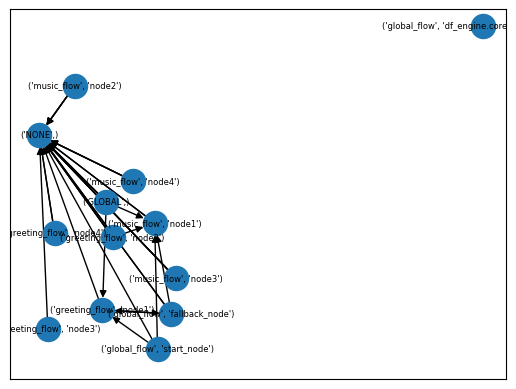

In [18]:
nx.draw_networkx(graph, font_size=6)

**_Note:_** labels from ``df_engine.core.labels`` such as ``df_engine.core.labels.repeat`` are not yet supported and edges that use them refer to a node ``("NONE", )`` instead.